In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/robert/Bob-Ross.jpg
/kaggle/input/flat-earth-lol/flat earth lol.mp3
/kaggle/input/a-brief-history-of-time/A Brief History of Time ( PDFDrive ).pdf


## ⚙️ Setting up and Configuring the Envoirment


In [2]:
!pip uninstall -qyy jupyterlab 
!pip install -qU "google-genai==1.9.0"
!pip install -qU langchain-google-genai
!pip install -q PyMuPDF
!pip install -q google-cloud-speech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import json
import fitz
import google.generativeai
from google import genai
from google.genai import types
from langchain_google_genai import ChatGoogleGenerativeAI
from PIL import Image
from IPython.display import display, Image, Markdown, Audio
from google.cloud import speech


genai.__version__

'1.9.0'

## 🔑 API Configuration and Model Setup

In [4]:
#settings up the API key🤫
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
google.generativeai.configure(api_key=GOOGLE_API_KEY)

In [6]:
#making use of the retry helper so that i can run all without worrying about the per-minute quota
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

In [7]:
model = google.generativeai.GenerativeModel("gemini-2.0-flash")

## 📄 Document Processing Implementation

1) Load the document. Personally I used the Brief History of Time by Stephen Hawking
2) Use PyMuPDF (fitz) to open, and iterate through each page and extract the text.
3) Combine all the text into a single string and return it.
4) Created a promt for the gemini model, to summarize it and then reflect on the space facts learned from book.

In [8]:
path = "/kaggle/input/a-brief-history-of-time/A Brief History of Time ( PDFDrive ).pdf"

def extract_text_from_pdf(path):
    doc = fitz.open(path)
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()
    return text.strip()

pdf_text = extract_text_from_pdf(path)
print("📄 PDF Text Preview:\n", pdf_text[:1000])

📄 PDF Text Preview:
 ALSO BY STEPHEN HAWKING
A Briefer History of Time
Black Holes and Baby Universes and Other Essays
The Illustrated A Brief History of Time
The Universe in a Nutshell
The Grand Design
FOR CHILDREN
George’s Secret Key to the Universe (with Lucy Hawking)
George’s Cosmic Treasure Hunt (with Lucy Hawking)
A BRIEF HISTORY OF TIME
A Bantam Book
Publishing History
Bantam illustrated hardcover edition published November 1996
Bantam hardcover edition/September 1998
Bantam trade paperback edition/September 1998
All rights reserved.
Copyright © 1988, 1996 by Stephen Hawking
Illustrations copyright © 1988 by Ron Miller
BOOK DESIGN BY GLEN M. EDELSTEIN
No part of this book may be reproduced or transmitted in any form or by any means, electronic
or mechanical, including photocopying, recording, or by any information storage and retrieval
system, without permission in writing from the publisher. For information address: Bantam
Books.
Library of Congress Cataloging-in-Publication Da

In [9]:
doc_understanding_prompt = f"""
You are Neil deGrasse Tyson. Summarize the doc attached, written by your late friend: Stephen Hawking.
What are some of the most important space facts did you learn?

Document:
{pdf_text}
"""

doc_response = model.generate_content(doc_understanding_prompt)

In [10]:
Markdown(doc_response.text)

Okay, alright, let's break this down with a little cosmic perspective, shall we? This document, *A Brief History of Time*, written by my late friend Stephen Hawking, is essentially a sweeping survey of cosmology, from ancient ideas about the universe to modern attempts at a unified theory.

He begins with the historical development of our understanding of the universe, tracing it from Aristotle's earth-centered model through Copernicus, Galileo, and Newton. It moves on to Einstein's theories of relativity and their implications for space, time, and gravity.

Hawking then discusses the expanding universe, the Big Bang theory, and the evidence supporting it, such as the cosmic microwave background radiation. The book also delves into quantum mechanics, the uncertainty principle, and the wave-particle duality.

A significant portion is dedicated to black holes – Stephen's specialty! – and how they challenge our understanding of space-time. He touches on the important concept of Hawking radiation, which reveals that black holes aren't entirely black, and introduces the concept that they can eventually evaporate over unimaginably long timescales.

Finally, the book grapples with the quest for a unified theory of everything, exploring ideas like supergravity, string theory, M-theory, and the role of extra dimensions. Hawking concludes by pondering the ultimate questions of existence, the anthropic principle, and the possibility of a self-contained universe without boundaries, ultimately asking if a complete theory would even require a creator.

Essentially, it's a mind-expanding journey through the history of cosmology and the biggest questions about our universe and the very nature of reality, presented in a (relatively!) accessible way for the general public.

Now, about those space facts that stuck with me most from this work. Let's face it, I know a *lot* about space... but even I can learn a few things, and Stephen was one of the few people who could truly challenge my understanding:

*   **The sheer audacity of the "no boundary proposal":** I admire Stephen's courage in exploring the possibility that the universe is finite yet without boundaries – a concept that truly warps the mind. The idea that imaginary time could allow for a universe without a singular beginning and end is profound, whether it's true or not.
*   **That thought on naked singularities:** The fact that not all singularities in space-time are actually hidden inside black holes. Now I was betting with Kip Thorne and John Preskill as to if the "Cosmic Censorship" was in fact true.
*   **The importance of even a theory for the early universe being well tested.** Any theory should be testable via gamma ray.

Ultimately, this book reminds us that while we may never have all the answers, the pursuit of knowledge, the asking of questions, and the relentless testing of our ideas is what makes us human and what drives us closer to understanding the universe. It was a brilliant contribution to humanity, and I miss my friend deeply.


## 🖼️ Image Processing Implementation

1) Loaded the image. In this case, a pic of Bob Ross landscape painting.
2) Use the Image class (from IPython.display) to display the image visually in the notebook.
3) Prepare a prompt asking the Gemini model to describe the painting in detail and reflect on how it makes the viewer feel.
4) Pass both the prompt and the image together to the model.generate_content() function.
5) Display the model’s output, which typically includes a vivid description of the scene, artistic techniques, and emotional impact.

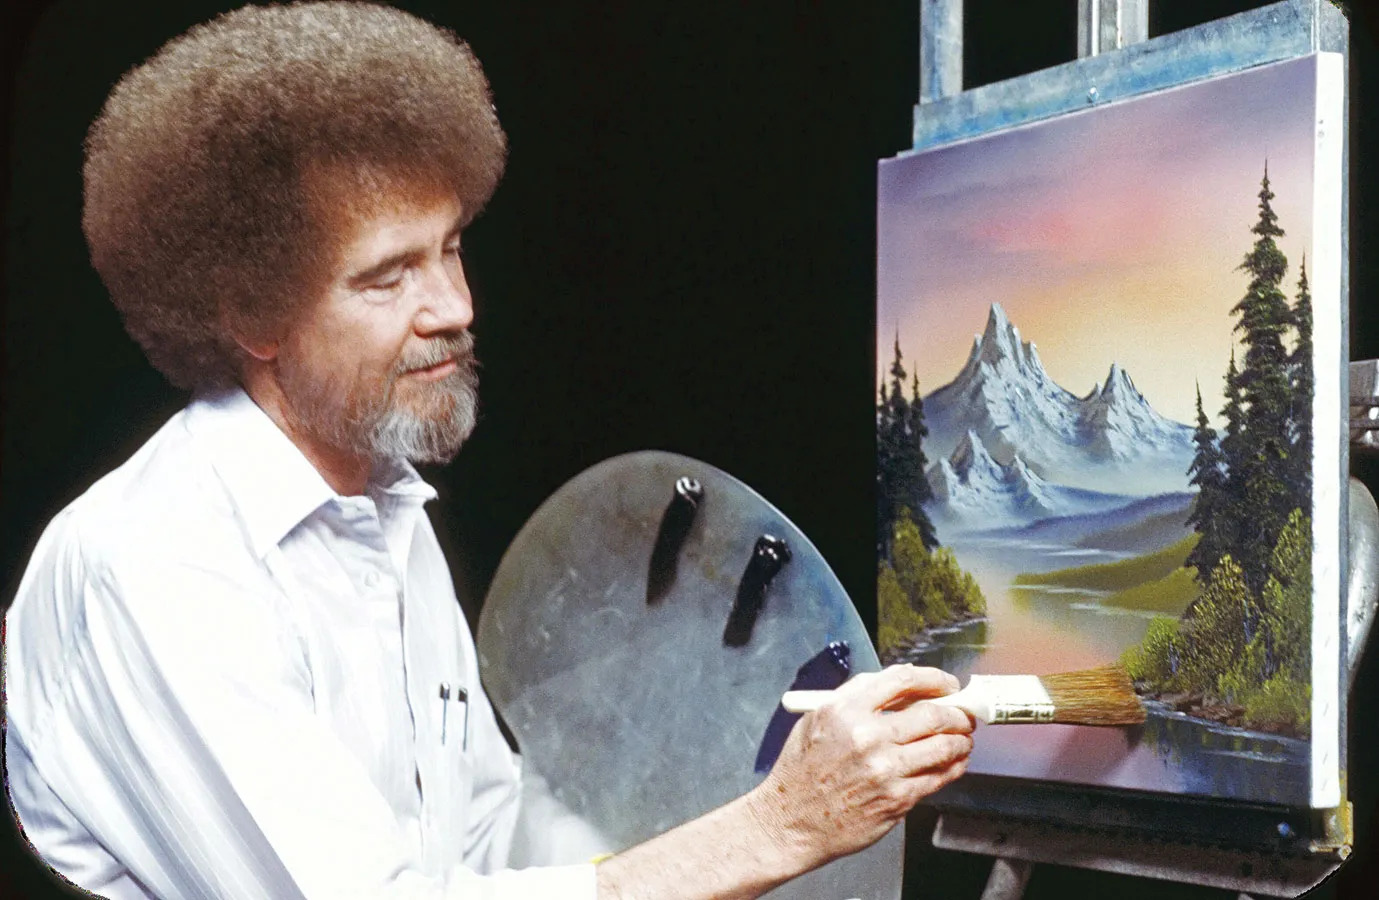

In [11]:
image_path = "/kaggle/input/robert/Bob-Ross.jpg"
img = Image(image_path, width=500)
img

In [12]:
image_response = model.generate_content(
    ["Describe this image in detail. How does it make you feel?",
     img]
)

In [13]:
print(image_response.text)

The image features Bob Ross, the beloved painter and television personality, in his element. He is positioned in front of a black background, which makes his figure and artwork stand out. He's wearing a white, button-down shirt with a pen tucked into the pocket, his signature large afro framing his face. He has a kind, gentle expression as he gazes at the painting in front of him.

In his left hand, he holds a large, round painter's palette with a few globs of black paint visible. His right hand holds a wide paintbrush, which he is using to add details to his landscape painting.

The painting itself, held in an easel, is a classic Bob Ross scene. It depicts snow-capped mountains in the distance under a soft, colorful sunset sky. Below the mountains, a calm river flows through a landscape of lush green trees and foliage. The painting evokes a sense of tranquility and natural beauty.

The image evokes a sense of calm, nostalgia, and creativity. Bob Ross's gentle demeanor and encouraging 

## 🧠 Few-Shot Prompting

1) Created a text prompt that includes few-shot examples showing how to convert natural language instructions into corresponding Python functions.
2) Each example in the prompt includes a clear instruction and the Python code that satisfies it.
3) The prompt ends with a new instruction but without the corresponding code — this is what the model is expected to complete.
4) Using `generate_content()` to process this structured prompt and produce the Python function for the last instruction.
5) Render the `json` result using Markdown to keep the code well-formatted and easy to read.

In [14]:
few_shot_prompt = """
You are a helpful assistant that converts natural language instructions into Python functions.
Follow the examples below and apply the pattern correctly to new instructions.

Example 1:
Instruction: "Write a function that adds two numbers."
python Code:
def add(a, b):
    return a + b

Example 2:
Instruction: "Create a function that checks if a number is even."
python Code:
def is_even(n):
    return n % 2 == 0

Example 3:
Instruction:Make a function that returns the factorial of a number.
python Code:
def factorial(n):
    if n == 0 or n == 1:
        return 1
    return n * factorial(n - 1)

Example 4:
Instruction:Write a function that returns the nth Fibonacci number.
python Code:
def fibonacci(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

Example 5:
Instruction:Write a function that returns all the prime factors of the given number in a list.
python Code:...
"""

response = model.generate_content(few_shot_prompt)
Markdown(response.text)

```python
def prime_factors(n):
    factors = []
    d = 2
    while d * d <= n:
        while n % d == 0:
            factors.append(d)
            n //= d
        d += 1
    if n > 1:
        factors.append(n)
    return factors
```

## 💽 Audio Understanding + JSON Parsing + Function Calling Implementation

1) Load an audio file (flat earth lol.mp3) and create an Audio() object to listen or visualize it.
2) Use the Gemini files.upload() API via genai.Client to upload the audio file.
3) Define a prompt asking the model to:
    * Transcribe the audio,
    * Summarize the main points,
    * Identify the speaker's intent.
4) Send the prompt and audio to Gemini using generate_content().
5) Parse the model’s raw JSON-formatted response:
    * First strip the markdown-style code block from the response,
    * Then load it into a Python dictionary using json.loads().
6) Create a helper function display_transcript():
    * Accepts the parsed JSON and a key (transcript, summary, or intent),
    * Displays the relevant portion clearly with formatting and error handling.

In [15]:
audio_path = "/kaggle/input/flat-earth-lol/flat earth lol.mp3"
Audio(audio_path)

In [16]:
client = genai.Client(api_key=GOOGLE_API_KEY)
speech = client.files.upload(file=audio_path)

In [17]:
audio_understanding_prompt = """
You are an aspiring astronomy/cosmology student attending a lecture from Neil deGrasse Tyson. The following is an audio recording from that lecture.
Your job is to:
1. Transcribe the audio
2. Summarize the main points
3. Identify the speaker's intent: Were they joking or being sarcastic in some parts? What else did they talk about?

Respond with structured output in the format:
{
  "transcript": "...",
  "summary": "...",
  "intent": "..."
}
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=[audio_understanding_prompt, speech]
)
print(response.text)

```json
{
  "transcript": "and to Earth. So if you put it on your computer, it's just kind like I said, see that it's Earth coming into view. It's like, okay. Yeah. I I'm pretty sure all the flat Earthers, it's really just a ploy so that they can get a free trip into space to be convinced of this. Uh, it's on an orbit from Earth that'll go out and meet Mars. And so if you're going to send anything to Mars, this is a minimum energy transfer and uh, that's kind of what you need to do and you need heavy transport to bring people, supplies and the like. The, I just got to see this, minutes later, it's truncated, but it's very cool. So the two boosters come back.",
  "summary": "The speaker discusses a video of Earth coming into view from space and jokes that flat-earthers are just trying to get a free trip to space to be convinced the Earth is round. He mentions the trajectory of an orbit from Earth designed to meet Mars, explaining that it minimizes energy transfer, which is necessary for

In [18]:
#clean the text
raw_text = response.candidates[0].content.parts[0].text
clean_text = raw_text.strip("```json\n").strip("```")
data = json.loads(clean_text)

In [19]:
#write a function to parse JSON, and display whatever the required/asked parameter is 
def display_transcript(data, part="transcript"):
    if part in data:
        print(f"\n🧩 {part.capitalize()}:\n{data[part]}")
    else:
        print(f"⚠️ Invalid key: '{part}'. Choose from: transcript, summary, intent.")

In [20]:
display_transcript(data, part="transcript")


🧩 Transcript:
and to Earth. So if you put it on your computer, it's just kind like I said, see that it's Earth coming into view. It's like, okay. Yeah. I I'm pretty sure all the flat Earthers, it's really just a ploy so that they can get a free trip into space to be convinced of this. Uh, it's on an orbit from Earth that'll go out and meet Mars. And so if you're going to send anything to Mars, this is a minimum energy transfer and uh, that's kind of what you need to do and you need heavy transport to bring people, supplies and the like. The, I just got to see this, minutes later, it's truncated, but it's very cool. So the two boosters come back.


In [21]:
display_transcript(data, part="summary")


🧩 Summary:
The speaker discusses a video of Earth coming into view from space and jokes that flat-earthers are just trying to get a free trip to space to be convinced the Earth is round. He mentions the trajectory of an orbit from Earth designed to meet Mars, explaining that it minimizes energy transfer, which is necessary for transporting people and supplies. He then previews a section of the video showcasing the return of the rocket boosters.


In [22]:
display_transcript(data, part="intent")


🧩 Intent:
The speaker is lecturing about space travel and uses humor to engage the audience when he jokes about the flat-earthers. He also seemed excited to share certain parts of the video of a space mission such as the boosters coming back and points out some of its features.


# Project Summary: GenAI Capstone – Multimodal Intelligence Demonstration

This capstone project showcases the power and versatility of Google’s Gemini model by building a multimodal AI assistant capable of processing and understanding various data types including documents, images, and audio. The project also explores structured prompting techniques such as few-shot learning, along with post-processing logic such as JSON parsing and function calling for dynamic interactivity.

## 📚 Key Concepts & Learnings

### 📄 Document Understanding
- Used `PyMuPDF (fitz)` to extract raw text from a PDF (e.g., *A Brief History of Time*).
- Prompted Gemini to summarize the document and reflect on key learnings.
- Learned to structure prompts for long-form content summarization.

### 🖼️ Image Processing
- Loaded a Bob Ross painting and used Gemini to describe the image in detail.
- Emphasized emotional and visual perception through prompt design.
- Learned to use `IPython.display.Image` to inject visual content into Gemini prompts.

### 🎧 Audio Understanding
- Created a structured prompt to transcribe, summarize, and detect speaker intent.
- Demonstrated how Gemini handles spoken input and returns JSON-structured output.

### 💡 Few-Shot Prompting
- Created a few-shot learning prompt to convert natural language instructions into Python functions.
- Demonstrated pattern learning via clear examples.
- Learned how to guide the model using syntactic and semantic cues.

### 🧾 JSON Parsing
- Parsed model responses using `json.loads()` after cleaning markdown-wrapped text.
- Built custom logic to dynamically extract specific fields (`transcript`, `summary`, `intent`) from model output.
- Learned to handle structured outputs with flexibility and robustness.

### ⚙️ Function Calling
- Created a helper function `display_transcript()` to encapsulate the logic for field selection.
- Demonstrated programmatic access to AI responses based on user input.
- Learned to modularize model interaction for reuse and maintainability.
